In [1]:
import crispr_assembler as ca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

%load_ext autoreload
%autoreload 2

import pickle

In [2]:
def process_path(path, cut = -1, save = 1):
    pairs_path = path + "/out/pairs/"
    files = sorted(os.listdir(pairs_path))
    
    print(pairs_path + files[0])
    
    read = ca.Read(pairs_path + files[0])
    read.correct_errors(minimum_occurences=5)
    gr = read.graph_from_pairs()[0]
    
    print('calc embs')
    ec = ca.EmbeddingsCalculator()
    ec.make_argsorts(gr[:cut, :cut])
    embs = ec.fit_predict(gr[:cut, :cut], njobs=32)
    
    if save:
        pickle.dump(read, open(path + "/read", 'wb'))
        np.save(path + "/graph", gr)
        np.save(path + "/embs", embs)
        
    return read, gr, embs

In [3]:
def load(path):
    return pickle.load(open(path + "/read", 'rb')), np.load(path + "/graph.npy"), np.load(path + "/embs.npy", embs)

In [4]:
def unwrap_idx_to_spacer(idx_to_spacer):
    values_as_list = []
    for i in range(len(idx_to_spacer)):
        values_as_list.append(idx_to_spacer[i])
    return values_as_list

In [5]:
def continue_steps(reads, pointers):
    return any([pointers[i] < len(reads[i]) for i in range(len(reads))])

In [6]:
def merge_reads(reads, t=1, v = 1):
    spacers_lists = [unwrap_idx_to_spacer(x) for x in reads]#[unwrap_idx_to_spacer(x.index_to_cluster) for x in reads]
    pointers = [0 for i in range(len(reads))]
    merged_sp_to_idxes = {}
    old_idx_to_new_idx = [{} for i in range(len(reads))]
    
    curr = 0
    while continue_steps(spacers_lists, pointers):
        for i in range(len(reads)):
            if pointers[i] < len(reads[i]):
                spacer = spacers_lists[i][pointers[i]]
                
                dist, closest = ca.find_closest(merged_sp_to_idxes, spacer)
                if dist > t:
                    merged_sp_to_idxes[spacer] = curr
                    #new_sp_to_ids[i][spacer] = curr
                    old_idx_to_new_idx[i][pointers[i]] = curr
                    curr += 1
                else:
                    old_idx_to_new_idx[i][pointers[i]] = merged_sp_to_idxes[closest]
                
                pointers[i] += 1
                
                if curr % 100 == 0:
                    print(curr)
                

                if v:
                    print(i, pointers[i], spacer, dist, merged_sp_to_idxes)#, new_sp_to_ids[1])
                    
    return merged_sp_to_idxes,  old_idx_to_new_idx

In [7]:
def rearange(gr, order):
    new_gr = np.zeros((max(order.values()) + 1, max(order.values()) + 1))

    for i in tqdm.tqdm(range(len(order.keys()))):
        for j in range(len(order.keys())):
            new_gr[order[i], order[j]] = gr[i, j]

    return new_gr

In [9]:
paths = [
    '/home/rykachevskiy/CRISPR_research/data/environmental/slv1/',
    '/home/rykachevskiy/CRISPR_research/data/environmental/slv2/',
    '/home/rykachevskiy/CRISPR_research/data/environmental/slv3/'
]



In [10]:
res_all = [process_path(x) for x in paths]

  0%|          | 0/321 [00:00<?, ?it/s]

/home/rykachevskiy/CRISPR_research/data/environmental/slv1//out/pairs/SlV1_GTGGCC_L001_R1_001.fastq.gz_pairs.txt


100%|██████████| 321/321 [00:00<00:00, 3286.76it/s]


calc embs


  0%|          | 0/307 [00:00<?, ?it/s]

/home/rykachevskiy/CRISPR_research/data/environmental/slv2//out/pairs/SlV2_GTTTCG_L001_R1_001.fastq.gz_pairs.txt


100%|██████████| 307/307 [00:00<00:00, 3213.78it/s]


calc embs


  0%|          | 0/358 [00:00<?, ?it/s]

/home/rykachevskiy/CRISPR_research/data/environmental/slv3//out/pairs/SlV3_CGTACG_L001_R1_001.fastq.gz_pairs.txt


100%|██████████| 358/358 [00:00<00:00, 2888.86it/s]


calc embs


In [11]:
reads = [x[0] for x in res_all]
grs = [x[1] for x in res_all]
embs = [x[2] for x in res_all]

In [12]:
merged, old_to_new = merge_reads([x.index_to_cluster for x in reads], t = 5, v = 0)

100
100
100
200
300


In [13]:
grs_m = [rearange(grs[i], old_to_new[i]) for i in range(3)]

100%|██████████| 331/331 [00:00<00:00, 10655.41it/s]


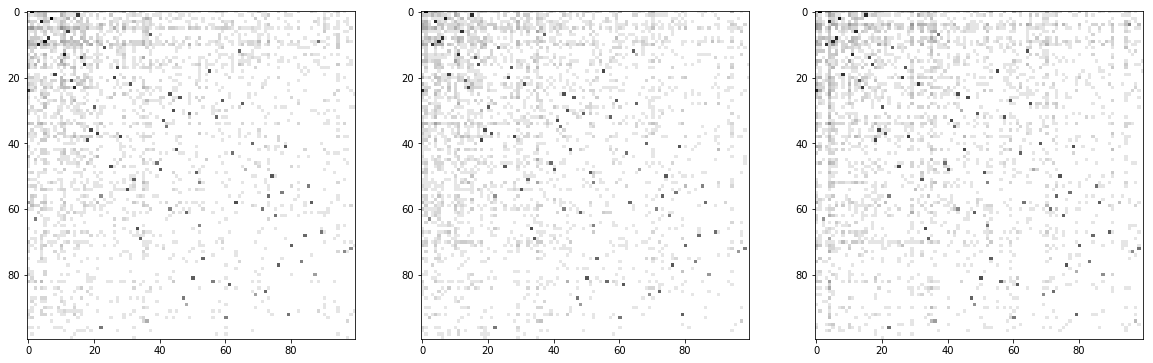

In [15]:
cut = 100
ca.plot_grs(grs_m[0][:cut, :cut],
            grs_m[1][:cut, :cut],
            grs_m[2][:cut, :cut],
            log = 1, 
            s = 20)
plt.show()

In [27]:
grs_m[0][0].astype(int)[:10]

array([  0, 761,   5,  11,   7,   9,   3,   3,   3,   2])

In [26]:
grs_m[2][0].astype(int)[:10]

array([  2, 764,   0,   8,  18,   3,   3,   2,   3,   1])

In [17]:
gb = pickle.load(open("./gb_rep_to_rep", 'rb'))

In [23]:
preds = gb.predict_proba(embs[1])[:,1].reshape((289, 289))

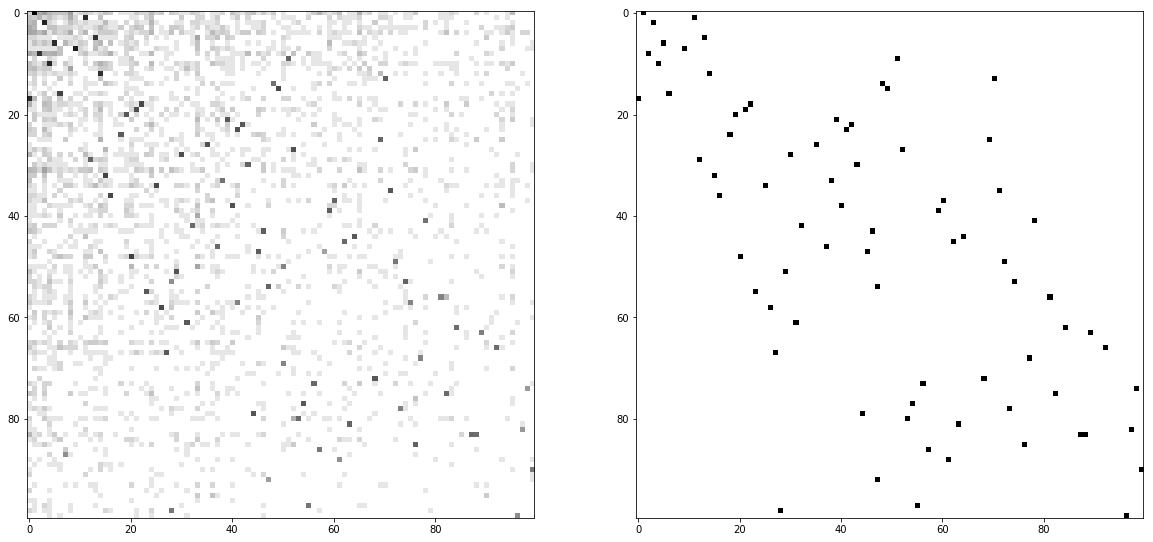

In [24]:
cut = 100
ca.plot_grs(grs[1][:cut,:cut], preds[:cut,:cut] > 0.5, log =1, s = 20)

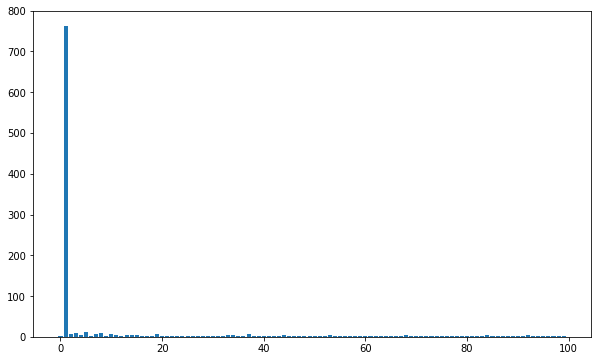

In [29]:
plt.figure(figsize = (10, 6))
plt.bar(np.arange(cut), grs[0][0][:cut] + 1)
plt.show()

In [29]:
def get_top_stats(graph, i, cut=10, axis=0):
    return np.array(sorted(graph[i])[::-1][:10]), np.argsort(graph[i])[::-1][:10]

In [35]:
get_top_stats(gr, 28)

(array([877, 292,  79,  25,  13,   8,   7,   7,   7,   6]),
 array([ 31,  25,  74,  53, 242,   2,   4,  20, 190,   5]))

In [37]:
get_top_stats(preds, 28)

(array([  9.99639410e-01,   2.77795110e-01,   6.13370253e-02,
          2.40353250e-03,   1.60886381e-03,   1.60886381e-03,
          2.82336667e-04,   1.58908208e-04,   1.58908208e-04,
          1.58908208e-04]),
 array([ 31,  25,  74, 242, 493, 190,  53,   6,  18,  49]))

In [38]:
preds[28, 53]

0.00028233666681546548

In [40]:
embs_sq = embs.reshape(gr.shape[0], gr.shape[1], 6)

In [41]:
embs_sq[28][31]

array([ 1.        ,  1.        ,  0.63781818,  0.95016251,  6.77764659,
        6.77764659])

In [42]:
embs_sq[28][25]

array([ 0.99960815,  1.        ,  0.21236364,  0.64317181,  5.68017261,
        5.68017261])

In [50]:
for v, i in zip(*get_top_stats(preds, 28)):
    print(v, embs_sq[28][i])

0.999639409933 [ 1.          1.          0.63781818  0.95016251  6.77764659  6.77764659]
0.277795109973 [ 0.99960815  1.          0.21236364  0.64317181  5.68017261  5.68017261]
0.0613370252526 [ 0.9992163   1.          0.05745455  0.76699029  4.38202663  4.38202663]
0.00240353249703 [ 0.9984326   1.          0.00945455  1.          2.63905733  2.63905733]
0.00160886381019 [ 0.9960815   1.          0.00363636  0.83333333  1.79175947  1.79175947]
0.00160886381019 [ 0.9968652   1.          0.00509091  0.77777778  2.07944154  2.07944154]
0.000282336666815 [ 0.99882445  1.          0.01818182  0.3968254   3.25809654  3.25809654]
0.000158908207799 [  9.92554859e-01   9.79623824e-01   1.45454545e-03   7.51314801e-04
   1.09861229e+00   1.09861229e+00]
0.000158908207799 [  9.86285266e-01   9.61990596e-01   7.27272727e-04   9.17431193e-04
   6.93147181e-01   6.93147181e-01]
0.000158908207799 [  9.90987461e-01   9.93730408e-01   7.27272727e-04   2.90697674e-03
   6.93147181e-01   6.93147181e-01

In [48]:
grs[0].shape

(297, 297)

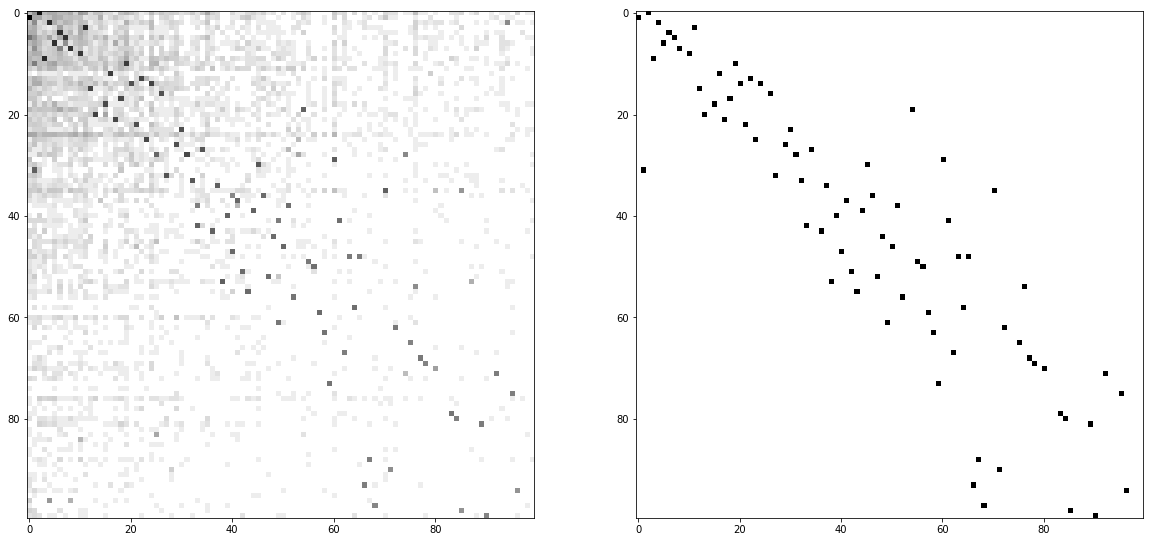

In [23]:
cut = 100
ca.plot_grs(gr[:cut, :cut], preds[:cut, :cut], s = 20, log = 1)

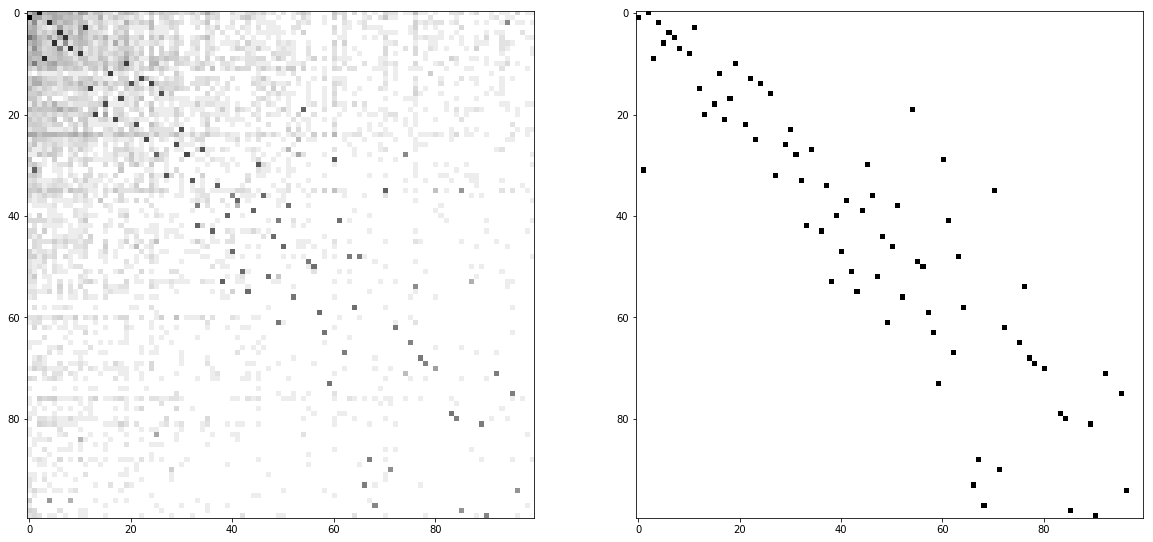

In [12]:
cut = 100
ca.plot_grs(gr[:cut, :cut], gr_restored[:cut, :cut], s = 20, log = 1)

In [63]:
grs[1][1]

array([  4,   3,   6,   2,   4,   2,   1,   2,   8,   2,   0, 296,   0,
         0,   4,   0,   0,   0,   0,   0,   1,   1,   0,   2,   4,   0,
         0,   0,   0,   0,   3,   0,   0,   2,   2,   0,   1,   3,   0,
         0,   1,   3,   0,   2,   0,   0,   0,   0,   1,   0,   1,   1,
         1,   0,   0,   2,   0,   0,   0,   2,   0,   2,   1,   1,   1,
         2,   0,   0,   0,   2,   2,   1,   0,   0,   1,   1,   0,   0,
         0,   0,   0,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   1,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         1,   0,   1,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   2,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         3,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [10]:
def calc_noise_ratio(gr0, gr):
    return 1 - gr[gr0>0].sum() / gr.sum(), ((gr > 0).sum() - (gr0 > 0).sum()) / gr.flatten().shape[0]

In [6]:
arrs, weights = ca.restore_arrays_greedy(gr, threashold=2)

In [7]:
gr_restored = ca.graph_from_arrays(arrs, gr.shape[0])[0]

In [13]:
len([x for x in arrs if len(x) > 3])

46

In [43]:
calc_noise_ratio(gr_restored[:500, :500], gr[:500, :500])

(0.15619127416362444, 0.020043999999999999)

In [44]:
calc_noise_ratio(gr_restored[:100, :100], gr[:100,:100])

(0.13019157400241677, 0.27779999999999999)

In [56]:
filtered_medians = [np.median(y) for y in ca.get_weights(grs[1],[x for x in ca.restore_arrays_all(preds > 0.5) if len(x) > 2]) if np.median(y) > 5]

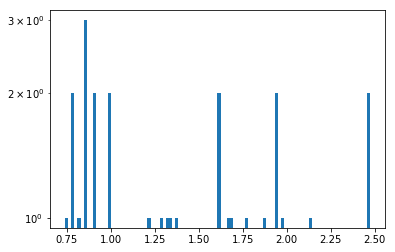

In [57]:
plt.hist([np.log10(filtered_medians)], bins = 100, log = 1)
plt.show()

# cut gr

In [24]:
ec =ca.EmbeddingsCalculator()
ec.make_argsorts(gr[:100,:100])

In [25]:
embs2 = ec.build_embeddings(gr[:100,:100])

Process ForkPoolWorker-32:
Process ForkPoolWorker-26:
Process ForkPoolWorker-30:
Process ForkPoolWorker-31:
Process ForkPoolWorker-28:
Traceback (most recent call last):
Process ForkPoolWorker-27:
Traceback (most recent call last):
Process ForkPoolWorker-29:
Traceback (most recent call last):
Process ForkPoolWorker-25:
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.

In [26]:
preds2 = gb.predict(embs2).reshape(gr[:100,:100].shape)

In [30]:
embs2_sq = embs2.reshape(100,100, -1)

In [51]:
embs_sq = embs.reshape(gr.shape[0], gr.shape[1], -1)

In [52]:
gb.predict_proba(embs_sq[2, 5].reshape(1,-1))

array([[0.61947113, 0.38052887]])

In [66]:
gb.predict_proba(embs2_sq[2, 5].reshape(1,-1))

array([[0.99736337, 0.00263663]])

In [54]:
embs_sq[2, 5]

array([1.        , 1.        , 0.28552368, 0.29215017, 6.06145692,
       6.06145692])

In [55]:
gb.predict_proba([[1., 1., 0.28552368, 0.29215017, 6.06145692, 6.06145692]])

array([[0.61947113, 0.38052887]])

In [57]:
gr[2][:10]

array([ 53,  98,   7,  54,  30, 428,  28,  12,  17,  19])

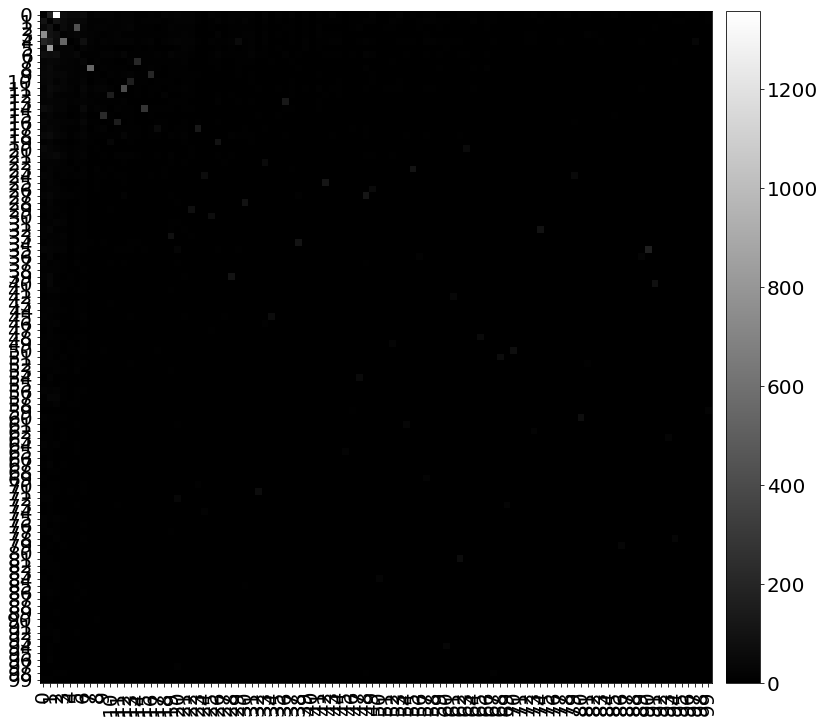

In [72]:
ca.plot_gr(gr[:100, :100], s = 20, all_ticks=1)

In [ ]:
2 5 1 

In [70]:
get_top_stats(gr, 2)

(array([428,  98,  54,  53,  30,  28,  24,  19,  18,  17]),
 array([ 5,  1,  3,  0,  4,  6, 13,  9, 12,  8]))

In [68]:
gr[1].sum()

1758

In [69]:
gr[:, 1].sum()

3733

In [ ]:
0

In [27]:
gr.shape

(2165, 2165)

In [6]:
cut = 100
ca.plot_grs(gr[:cut, :cut], preds2[:cut, :cut], s = 20, log = 1)

NameError: name 'preds2' is not defined

In [52]:
read =  ca.Read("../../data/SlO_10/SlO2_R1_pairs_10.txt")

In [55]:
read.correct_errors()

100%|██████████| 15890/15890 [00:44<00:00, 354.66it/s]


In [56]:
gr2 = read.graph_from_pairs()[0]

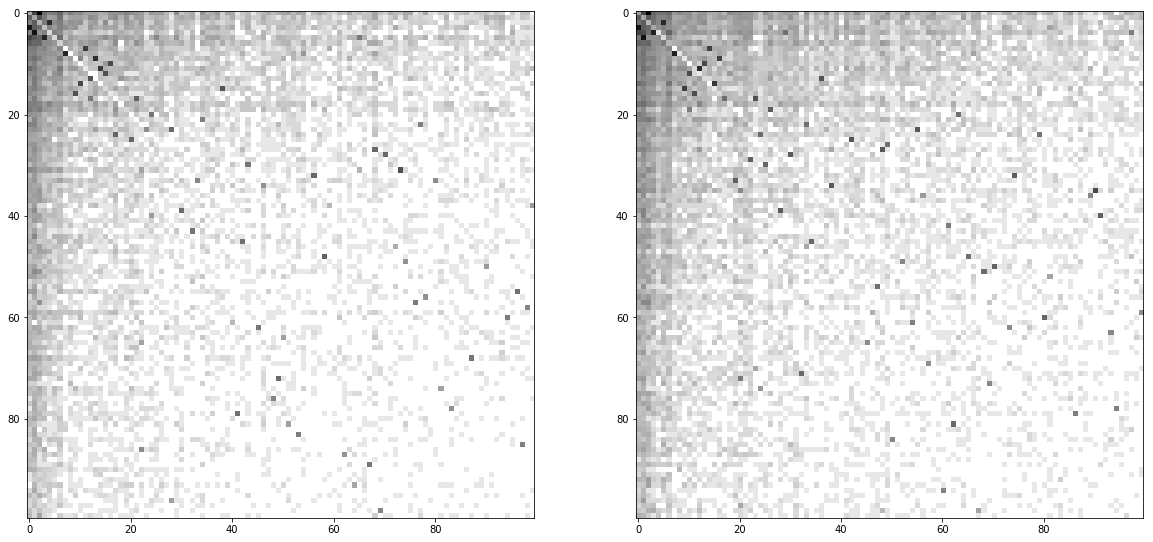

In [69]:
ca.plot_grs(gr2[:100, :100], gr[:100, :100], log = 1, s = 20)

In [81]:
def calc_noise_ratio(gr0, gr):
    return gr[gr0 > 0].sum() / (gr.sum() - gr[gr0 > 0].sum())

In [71]:
arrs, weights = ca.restore_arrays(gr)

In [72]:
restored_gr = ca.graph_from_arrays(arrs, gr.shape[0])[0]

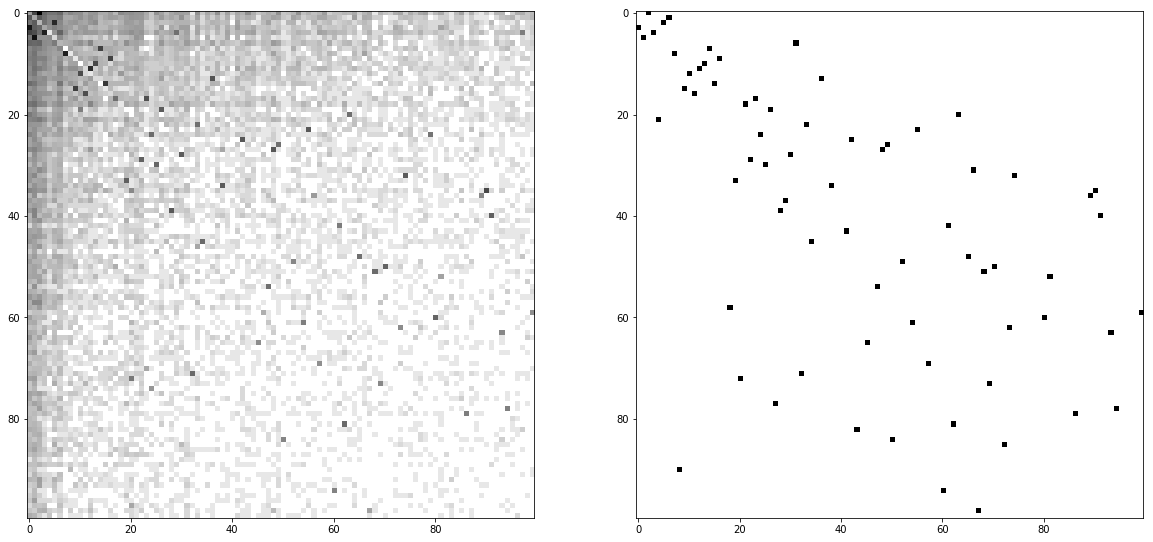

In [73]:
ca.plot_grs(gr[:100, :100], restored_gr[:100, :100], log = 1, s = 20)

In [79]:
gr[:10, :10]

array([[  15,  178, 1357,   73,   48,   48,   64,   18,   28,   22],
       [ 105,   11,  102,   57,   32,   32,   39,   11,   11,   15],
       [  53,   98,    7,   54,   30,  428,   28,   12,   17,   19],
       [ 748,   96,   69,   11,   23,   37,   25,   17,   14,    8],
       [ 200,  147,   60,  541,    1,   21,   80,   21,    9,   17],
       [  47,  840,   22,   22,   25,    2,   26,   11,    7,    8],
       [  77,   68,   77,   25,   23,   41,    7,    9,   10,   16],
       [  29,   42,   35,   24,   17,   14,   28,    0,   13,    7],
       [  33,   51,   23,   20,   16,   13,   14,  536,    1,   11],
       [  38,   46,   34,   35,   18,   11,   19,    8,   11,    1]])

In [82]:
calc_noise_ratio(restored_gr, gr)

0.29165781710914457

# PCA

In [52]:
from sklearn.decomposition import PCA

In [54]:
pca = PCA(2)

In [55]:
pca.fit(embs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [57]:
embs_2 =pca.transform(embs)

In [61]:
embs_2_cut =embs_2.reshape(gr.shape[0], gr.shape[1], 2)[:100, :100].reshape(10000, 2)

In [66]:
mask = (preds > 0.3)[:100, :100].reshape(10000)

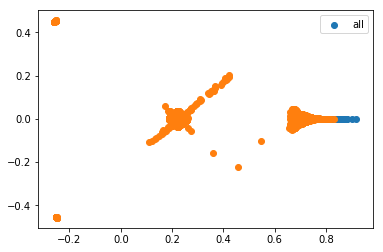

In [68]:
plt.scatter(embs_2_cut[mask, 0], embs_2_cut[mask, 1], label = 'all')
plt.scatter(embs_2_cut[np.logical_not(mask), 0], embs_2_cut[np.logical_not(mask), 1])
plt.legend()
plt.show()

### Mammoth


In [32]:
arrays_with_tags = ca.read_arrays_with_tags("./arrays_sp_mammonth", 0)

In [40]:
arrays_ids = ca.multiple_arrays_to_ids(arrays_with_tags, reads[1].cluster_to_index)[0]

100%|██████████| 156/156 [00:00<00:00, 415.06it/s]


In [43]:
gr_mamonth = ca.graph_from_arrays([x for x in arrays_ids.values()])[0]

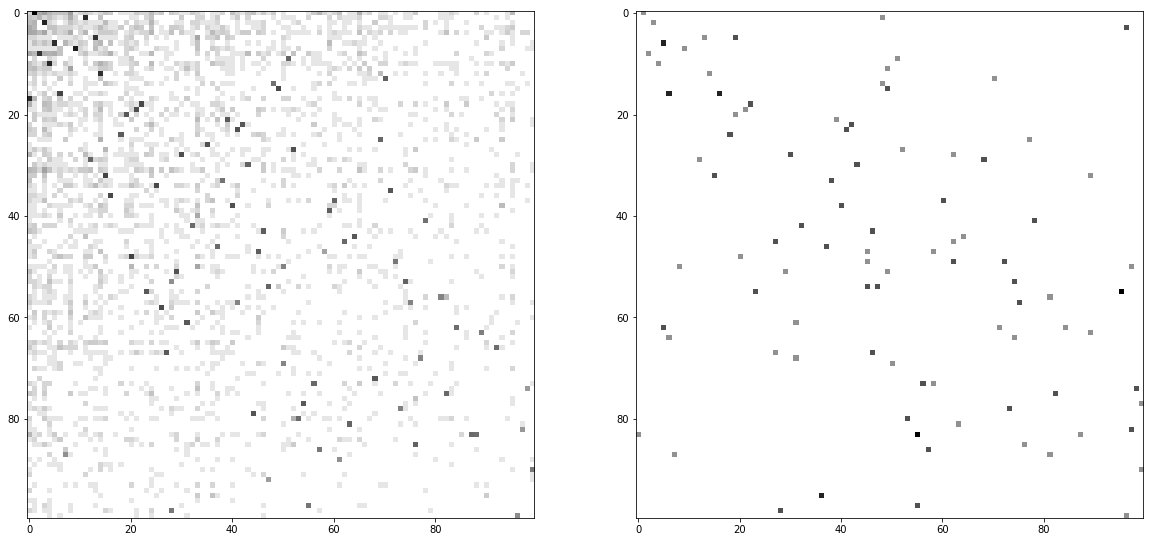

In [47]:
ca.plot_grs(grs[1][:cut, :cut], gr_mamonth[:cut, :cut], log = 1, s = 20)